# Hama Detection with CNN

In [1]:
!pip install jcopdl==1.1.1
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12607 sha256=b587074369cda00ee52bf17d0260b6a4158d7388496114f5955c6ff37a08cfeb
  Stored in directory: /root/.cache/pip/wheels/06/ce/6a/07bd2e8bea88a0430ef2a1b992aae7162fe7726d1aa1f5b45f
Successfully built jcopdl


In [2]:
!gdown https://drive.google.com//uc?id=1tL0kbNeYDCeG2zbAw7URcVdHqvX3Lm9T

Downloading...
From: https://drive.google.com//uc?id=1tL0kbNeYDCeG2zbAw7URcVdHqvX3Lm9T
To: /content/hama.zip
40.2MB [00:00, 110MB/s] 


In [ ]:
!unzip /content/hama.zip

## Import Library

In [4]:
import torch
import numpy as np 
from torch import nn, optim
from jcopdl.callback import Callback, set_config
import matplotlib.pyplot as plt
import seaborn as sns 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
features, target = next(iter(trainloader))
features.shape

torch.Size([64, 3, 224, 224])

In [8]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur & Config

In [9]:
from jcopdl.layers import conv_block, linear_block

In [10]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64, pool_kernel=4, pool_stride=4),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(3136, 256,  dropout=0.2),
            linear_block(256, output_size, activation='lsoftmax')
        ) 
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [11]:
config = set_config({
    'output_size': len(train_set.classes), 
    'bs': bs, 
    'crop_size': crop_size
})

## Training Preparation

In [12]:
model = CNN(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [13]:
from tqdm.auto import tqdm

In [14]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6911 | Test_cost  = 0.6870 | Train_score = 0.5350 | Test_score = 0.5000 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6595 | Test_cost  = 0.5846 | Train_score = 0.5880 | Test_score = 0.7250 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5393 | Test_cost  = 0.4677 | Train_score = 0.7450 | Test_score = 0.8025 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4467 | Test_cost  = 0.4391 | Train_score = 0.7960 | Test_score = 0.8075 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4370 | Test_cost  = 0.3746 | Train_score = 0.7970 | Test_score = 0.8550 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3712 | Test_cost  = 0.4022 | Train_score = 0.8380 | Test_score = 0.8325 |
==> EarlyStop patience =  1 | Best test_score: 0.8550


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3975 | Test_cost  = 0.3431 | Train_score = 0.8320 | Test_score = 0.8750 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3612 | Test_cost  = 0.3605 | Train_score = 0.8450 | Test_score = 0.8375 |
==> EarlyStop patience =  1 | Best test_score: 0.8750


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3462 | Test_cost  = 0.3040 | Train_score = 0.8440 | Test_score = 0.8875 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3155 | Test_cost  = 0.3153 | Train_score = 0.8620 | Test_score = 0.8875 |
==> EarlyStop patience =  1 | Best test_score: 0.8875


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2914 | Test_cost  = 0.2762 | Train_score = 0.8770 | Test_score = 0.9075 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2799 | Test_cost  = 0.2723 | Train_score = 0.8880 | Test_score = 0.8975 |
==> EarlyStop patience =  1 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2652 | Test_cost  = 0.2776 | Train_score = 0.8960 | Test_score = 0.8875 |
==> EarlyStop patience =  2 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2621 | Test_cost  = 0.2433 | Train_score = 0.8950 | Test_score = 0.9075 |
==> EarlyStop patience =  3 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2476 | Test_cost  = 0.2648 | Train_score = 0.9010 | Test_score = 0.8900 |
==> EarlyStop patience =  4 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2270 | Test_cost  = 0.2372 | Train_score = 0.9090 | Test_score = 0.9050 |
==> EarlyStop patience =  5 | Best test_score: 0.9075
==> Execute Early Stopping at epoch: 16 | Best test_score: 0.9075
==> Best model is saved at model


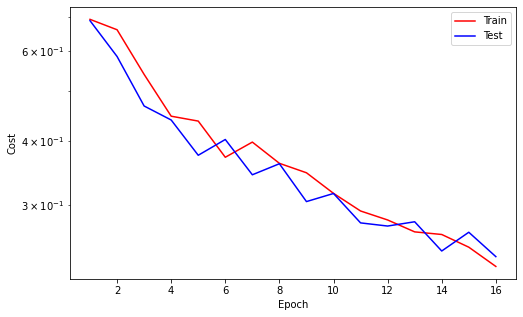

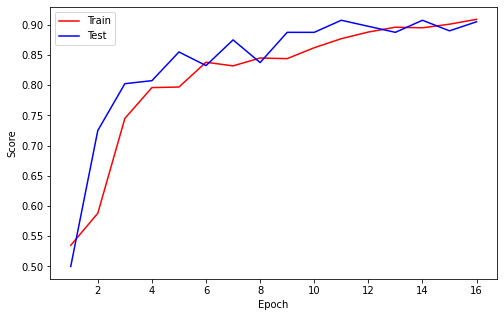

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Fine Tuning

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=1e-06)
callback.reset_early_stop()
callback.early_stop_patience = 7

Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2770 | Test_cost  = 0.2754 | Train_score = 0.8890 | Test_score = 0.9050 |
==> EarlyStop patience =  1 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2720 | Test_cost  = 0.2744 | Train_score = 0.8870 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2586 | Test_cost  = 0.2740 | Train_score = 0.8990 | Test_score = 0.9050 |
==> EarlyStop patience =  3 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2737 | Test_cost  = 0.2734 | Train_score = 0.8910 | Test_score = 0.9050 |


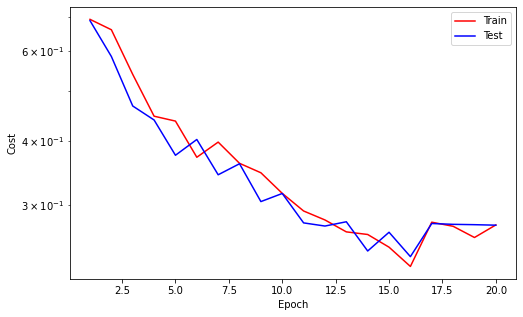

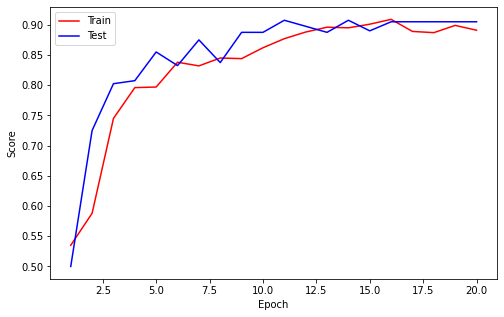

==> EarlyStop patience =  4 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2657 | Test_cost  = 0.2727 | Train_score = 0.8900 | Test_score = 0.9025 |
==> EarlyStop patience =  5 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2783 | Test_cost  = 0.2722 | Train_score = 0.8820 | Test_score = 0.9025 |
==> EarlyStop patience =  6 | Best test_score: 0.9075


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2709 | Test_cost  = 0.2720 | Train_score = 0.8890 | Test_score = 0.9025 |
==> EarlyStop patience =  7 | Best test_score: 0.9075
==> Execute Early Stopping at epoch: 23 | Best test_score: 0.9075
==> Best model is saved at model


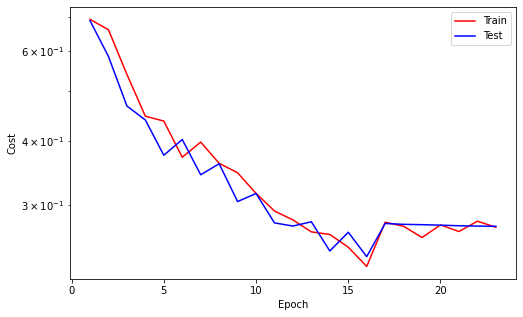

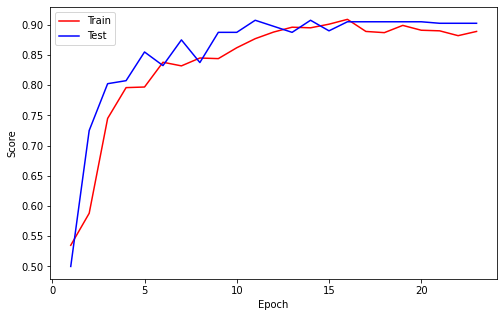

In [17]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Predict

In [22]:
features, target = next(iter(testloader))
features, target = features.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(features)
    y_pred = output.argmax(1)

In [24]:
train_set.class_to_idx

{'invasive': 0, 'noninvasive': 1}

## Sanity Check

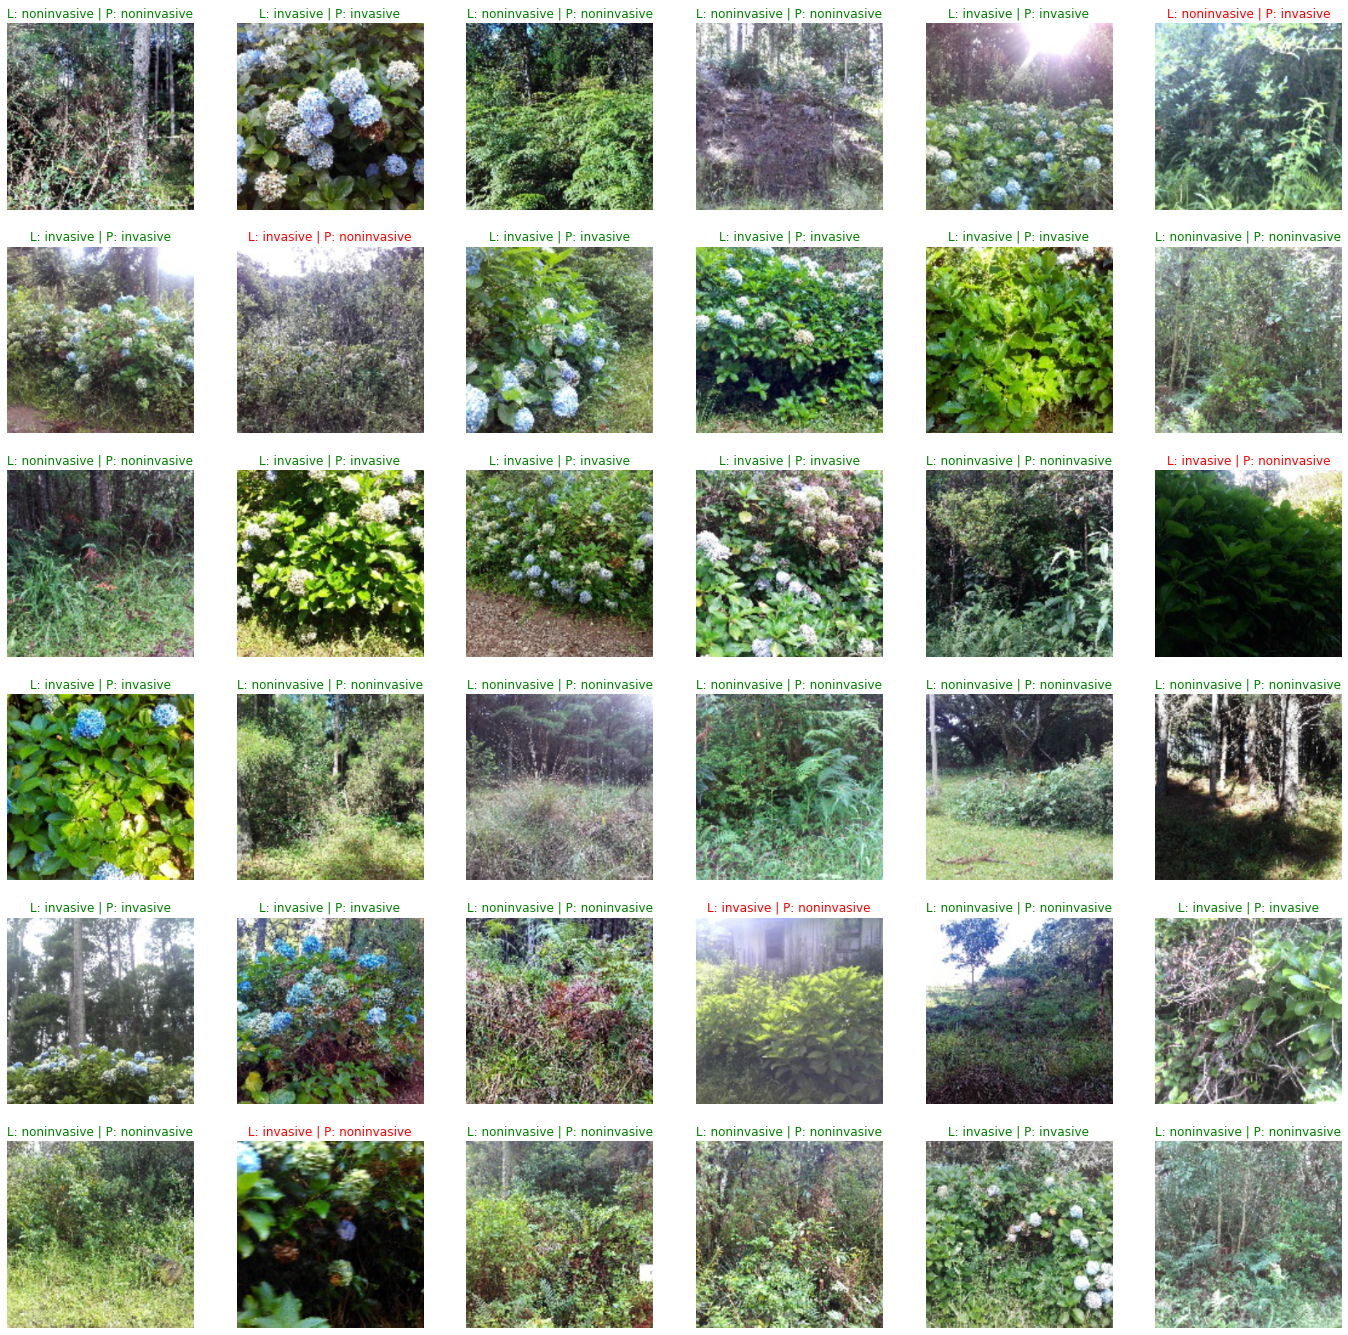

In [25]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(features, target, y_pred, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {'color': 'g'} if label == pred else {'color': 'r'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    
    ax.set_title(f'L: {label} | P: {pred}', fontdict=font);
    ax.axis('off');

## Evaluation

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [33]:
bs = len(test_set.samples)

test_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [34]:
features, target = next(iter(testloader))
features, target = features.to(device), target.to(device)

In [35]:
with torch.no_grad():
    model.eval()
    output = model(features)
    y_pred = output.argmax(1)
    y_pred = y_pred.to('cpu').numpy()
    target = target.to('cpu').numpy()

In [36]:
train_set.class_to_idx

{'invasive': 0, 'noninvasive': 1}

TEST
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       200
           1       0.91      0.91      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

Accuracy : 0.9075


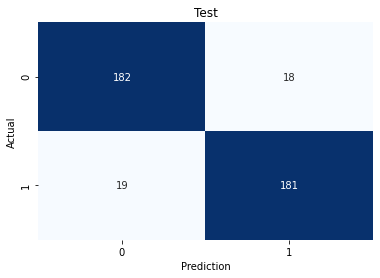

In [37]:
print('TEST')
print(classification_report(target, y_pred))
print('Accuracy :', accuracy_score(target, y_pred))

cm = confusion_matrix(target, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False, cmap='Blues')
plt.title('Test')
plt.xlabel('Prediction')
plt.ylabel('Actual');

In [38]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/logs.pth (deflated 37%)
  adding: content/model/configs.pth (deflated 52%)
  adding: content/model/weights_best.pth (deflated 8%)
